In [1]:
import os
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import backtrader as bt

In [3]:
from trackingfilters.kalman import LinKalmanFilter as lkf

In [4]:
%load_ext autoreload
%autoreload 2

In [8]:
sp500 = pd.read_csv("datasets/sp500_modified.csv").drop(['Unnamed: 0'], axis=1).set_index('DATE')

In [12]:
bank_df = sp500.loc[:, ['WFC', 'JPM']]

In [15]:
bank_return = bank_df.pct_change().dropna(how='any')

In [31]:
delta = 0.001
init_state_vec = np.zeros(1).reshape(-1,1)
init_state_cov_mat = np.ones((2,2))
process_noise_mat = delta/(1-delta) * np.eye(1)
transition_mat = np.eye(1)
control_mat = np.array([0]).reshape(-1,1)
control_vec = np.array([0]).reshape(-1,1)
observation_mat = np.array([1]).reshape(-1,1)
measure_noise_mat = np.array([1]).reshape(-1,1)

In [ ]:
kf = KalmanFilter(n_dim_obs=1, 
                  n_dim_state=1, 
                  initial_state_mean=init_state_vec,
                  initial_state_covariance=init_state_cov,
                  transition_matrices=transition_mat,
                  observation_matrices=observation_mat,
                  observation_covariance=measure_noise_mat,
                  transition_covariance=process_noise_mat)

In [ ]:
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=dim,
                          initial_state_mean=np.zeros(2),
                          initial_state_covariance=np.ones((2, 2)),
                          transition_matrices=np.eye(2),
                          observation_matrices=obs_matrix,
                          observation_covariance=obs_covariance,
                          transition_covariance=trans_cov)


In [34]:
stock_weighter = lkf(init_state_vec=init_state_vec, 
                    init_state_cov_mat = init_state_cov_mat,
                    transition_mat=transition_mat,
                    observation_mat=observation_mat,
                    control_vec=control_vec,
                    control_mat=control_mat,
                    process_noise_mat=process_noise_mat,
                    measure_noise_mat=measure_noise_mat)


cur_state_list = []
cur_cov_list = []

for index, row in bank_return.iterrows():
    cur_state, cur_cov = stock_weighter.update(row['JPM'])
    cur_state_list.append(cur_state[0][0])
    cur_cov_list.append(cur_cov[0][0])

In [35]:
res_array = np.array([np.array(x) for x in [cur_state_list, cur_cov_list]]).transpose()
res_df = pd.DataFrame(res_array, columns=['ESTIMATE', 'COVARIANCE'])

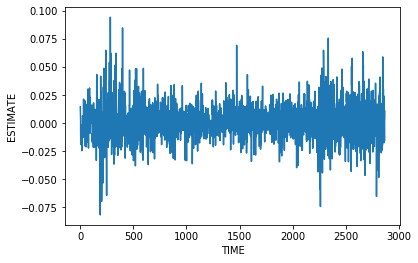

In [39]:
sns.lineplot(data=res_df, x='TIME', y='ESTIMATE')

In [38]:
res_df['TIME'] = res_df.index

In [43]:
from pykalman import KalmanFilter

In [47]:
bank_return.index = np.arange(0,len(bank_return))

In [56]:
def kalman_beta(df_return, ind_var, dep_var, delta=0.001, obs_covariance=1):
    size = len(df_return.index)
    dim = 2 # ind var, dep var
    
    state_means = np.zeros((size, dim))
    state_covs = np.zeros((size, dim, dim))
    ### Initialize Kalman Filter
    trans_cov = delta/(1 - delta) * np.eye(2)
    obs_matrix = [df_return.iloc[0][ind_var], 1]
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=dim,
                          initial_state_mean=np.zeros(2),
                          initial_state_covariance=np.ones((2, 2)),
                          transition_matrices=np.eye(2),
                          observation_matrices=obs_matrix,
                          observation_covariance=obs_covariance,
                          transition_covariance=trans_cov)
    
    i = 0
    
    for index, row in df_return.iterrows():
        obs_matrix = np.asarray([[df_return.iloc[index][ind_var], 1]])
        
        print(obs_matrix, 'obs_mat')
        print(df_return.iloc[index][dep_var], 'obs')
            
        if index == 0:
            state_means[0], state_covs[0] = kf.filter(np.asarray(df_return.iloc[index][dep_var]))
        else:
            state_means[index], state_covs[index] = kf.filter_update(state_means[index-1], 
                                                            state_covs[index-1], 
                                                            observation = df_return.iloc[index][dep_var], 
                                                            observation_matrix=obs_matrix)
        i += 1
        if i == 5:
            break

In [57]:
kalman_beta(bank_df, 'JPM', 'WFC')

[[10.0417  1.    ]] obs_mat
2.8281 obs
[[10.3333  1.    ]] obs_mat
2.7031 obs
[[10.375  1.   ]] obs_mat
2.6719 obs
[[10.4167  1.    ]] obs_mat
2.5938 obs
[[10.4167  1.    ]] obs_mat
2.6719 obs


In [51]:
bank_df.index = np.arange(0, len(bank_df))

In [59]:
x = bank_df['JPM']
y = bank_df['WFC']

In [63]:
obs_mat

array([[[10.0417,  1.    ]],

       [[10.3333,  1.    ]],

       [[10.375 ,  1.    ]],

       ...,

       [[46.375 ,  1.    ]],

       [[46.9375,  1.    ]],

       [[45.4375,  1.    ]]])

In [60]:
delta = 1e-3  
trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles  
obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional  
                  initial_state_mean=[0,0],  
                  initial_state_covariance=np.ones((2, 2)),  
                  transition_matrices=np.eye(2),  
                  observation_matrices=obs_mat,  
                  observation_covariance=2,  
                  transition_covariance=trans_cov)

# Use the observations y to get running estimates and errors for the state parameters  
state_means, state_covs = kf.filter(y.values)

In [67]:
kf.__name__

AttributeError: 'KalmanFilter' object has no attribute '__name__'

In [65]:
KalmanFilter.filter_update??

In [70]:
str(state_covs)

'[[[ 1.61395570e-02  1.61395570e-02]\n  [ 1.61395570e-02  1.61395570e-02]]\n\n [[ 8.20740840e-03  7.63826113e-03]\n  [ 7.63826113e-03  9.05023882e-03]]\n\n [[ 5.83940696e-03  4.72239617e-03]\n  [ 4.72239617e-03  7.52756446e-03]]\n\n ...\n\n [[ 1.53889271e-03 -4.38505441e-02]\n  [-4.38505441e-02  2.02245579e+00]]\n\n [[ 1.50767479e-03 -4.33742183e-02]\n  [-4.33742183e-02  2.02323699e+00]]\n\n [[ 1.56105837e-03 -4.40911265e-02]\n  [-4.40911265e-02  2.02369562e+00]]]'

In [80]:
np.zeros(shape=(3,5,1)).ndim

3

In [94]:
g = np.ones(shape=(1,5,1))

In [92]:
res = np.ones(shape=(5,1))

In [98]:
np.concatenate([g, res.reshape(1, res.shape[0], res.shape[1])])

array([[[1.],
        [1.],
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        [1.],
        [1.]]])

In [97]:
res.reshape(1, res.shape[0], res.shape[1])

array([[[1.],
        [1.],
        [1.],
        [1.],
        [1.]]])

In [101]:
a = np.concatenate(res.reshape(1, res.shape[0], res.shape[1]))

In [102]:
for i in a:
    print(i)

[1.]
[1.]
[1.]
[1.]
[1.]


In [103]:
a

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]])